# Evaluation Reporting Analytics

This notebook provides comprehensive analytics and reporting for document evaluation results stored in the ReportingDatabase.

## Features:
- Connect to Athena and load partitions for all evaluation tables
- Query and summarize evaluation results across documents, sections, and attributes
- Generate reports highlighting accuracy problems and trends
- Configurable filters for time range and document name patterns
- Track accuracy improvements/regressions over time

In [1]:
%pip install pandas matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully")

Libraries imported successfully


## Configuration

Set your ReportingDatabase name and AWS region here:

In [3]:
# Configuration - UPDATE THESE VALUES
REPORTING_DATABASE = "your-stack-name-reporting-db"  # Replace with your actual database name
REPORTING_DATABASE = "idp-reporting-5-reporting-db"
AWS_REGION = "us-west-2"  # Replace with your AWS region
S3_OUTPUT_LOCATION = "s3://your-athena-results-bucket/"  # Replace with your Athena results bucket
S3_OUTPUT_LOCATION = "s3://aws-athena-query-results-eu-west-2-912625584728"

# Configurable filters
DATE_RANGE_DAYS = 30  # Look back N days from today
DOCUMENT_NAME_FILTER = ""  # Filter documents containing this substring (empty = all documents)
MIN_ACCURACY_THRESHOLD = 0.8  # Highlight accuracy below this threshold

print(f"Configuration set for database: {REPORTING_DATABASE}")
print(f"Date range: Last {DATE_RANGE_DAYS} days")
print(f"Document filter: '{DOCUMENT_NAME_FILTER}' (empty = all documents)")
print(f"Accuracy threshold: {MIN_ACCURACY_THRESHOLD}")

Configuration set for database: idp-reporting-5-reporting-db
Date range: Last 30 days
Document filter: '' (empty = all documents)
Accuracy threshold: 0.8


## 1. Initialize Athena Connection

In [4]:
# Initialize AWS clients
athena_client = boto3.client('athena', region_name=AWS_REGION)
glue_client = boto3.client('glue', region_name=AWS_REGION)

def execute_athena_query(query, database=REPORTING_DATABASE):
    """
    Execute an Athena query and return results as DataFrame
    """
    try:
        response = athena_client.start_query_execution(
            QueryString=query,
            QueryExecutionContext={'Database': database},
            ResultConfiguration={'OutputLocation': S3_OUTPUT_LOCATION}
        )
        
        query_execution_id = response['QueryExecutionId']
        
        # Wait for query to complete
        while True:
            response = athena_client.get_query_execution(QueryExecutionId=query_execution_id)
            status = response['QueryExecution']['Status']['State']
            
            if status in ['SUCCEEDED', 'FAILED', 'CANCELLED']:
                break
                
        if status == 'SUCCEEDED':
            # Get results
            results = athena_client.get_query_results(QueryExecutionId=query_execution_id)
            
            # Convert to DataFrame
            columns = [col['Label'] for col in results['ResultSet']['ResultSetMetadata']['ColumnInfo']]
            data = []
            
            for row in results['ResultSet']['Rows'][1:]:  # Skip header row
                data.append([field.get('VarCharValue', '') for field in row['Data']])
            
            df = pd.DataFrame(data, columns=columns)
            return df
        else:
            error_reason = response['QueryExecution']['Status'].get('StateChangeReason', 'Unknown error')
            print(f"Query failed: {error_reason}")
            return None
            
    except Exception as e:
        print(f"Error executing query: {str(e)}")
        return None

print("Athena connection initialized")

Athena connection initialized


## 2. Load Partitions for All Tables

In [5]:
# Table names
tables = ['document_evaluations', 'section_evaluations', 'attribute_evaluations']

print("Loading partitions for all evaluation tables...")

for table in tables:
    try:
        print(f"\nLoading partitions for {table}...")
        
        # Run MSCK REPAIR to discover and load partitions
        repair_query = f"MSCK REPAIR TABLE {table}"
        result = execute_athena_query(repair_query)
        
        # Show partitions
        show_partitions_query = f"SHOW PARTITIONS {table}"
        partitions = execute_athena_query(show_partitions_query)
        
        if partitions is not None and not partitions.empty:
            print(f"Found {len(partitions)} partitions for {table}")
            print("Sample partitions:")
            print(partitions.head().to_string())
        else:
            print(f"No partitions found for {table}")
            
    except Exception as e:
        print(f"Error loading partitions for {table}: {str(e)}")

print("\nPartition loading completed")

Loading partitions for all evaluation tables...

Loading partitions for document_evaluations...
Error executing query: 0 columns passed, passed data had 1 columns
No partitions found for document_evaluations

Loading partitions for section_evaluations...
No partitions found for section_evaluations

Loading partitions for attribute_evaluations...
Error executing query: 0 columns passed, passed data had 1 columns
No partitions found for attribute_evaluations

Partition loading completed


## 3. Test Table Queries and Show Content Summaries

In [6]:
def test_table_query(table_name):
    """
    Test basic query on a table and show summary statistics
    """
    print(f"\n{'='*50}")
    print(f"Testing {table_name}")
    print(f"{'='*50}")
    
    # Test basic query
    test_query = f"SELECT * FROM {table_name} LIMIT 5"
    result = execute_athena_query(test_query)
    
    if result is not None and not result.empty:
        print(f"✓ Successfully queried {table_name}")
        print(f"Table has {len(result.columns)} columns")
        print(f"Columns: {list(result.columns)}")
        print("\nSample data:")
        print(result.to_string())
        
        # Get count
        count_query = f"SELECT COUNT(*) as total_records FROM {table_name}"
        count_result = execute_athena_query(count_query)
        if count_result is not None:
            total_records = count_result.iloc[0]['total_records']
            print(f"\nTotal records in {table_name}: {total_records}")
        
        return True
    else:
        print(f"✗ Failed to query {table_name} or table is empty")
        return False

# Test all tables
successful_tables = []
for table in tables:
    if test_table_query(table):
        successful_tables.append(table)

print(f"\n\nSummary: {len(successful_tables)}/{len(tables)} tables successfully queried")
print(f"Available tables: {successful_tables}")


Testing document_evaluations
✓ Successfully queried document_evaluations
Table has 14 columns
Columns: ['document_id', 'input_key', 'evaluation_date', 'accuracy', 'precision', 'recall', 'f1_score', 'false_alarm_rate', 'false_discovery_rate', 'execution_time', 'year', 'month', 'day', 'document']

Sample data:
            document_id             input_key          evaluation_date accuracy precision recall f1_score false_alarm_rate false_discovery_rate      execution_time  year month day              document
0  rvl_cdip_package.pdf  rvl_cdip_package.pdf  2025-06-10 22:08:58.185      1.0       1.0    1.0      1.0              0.0                  0.0  56.677573919296265  2025    06  10  rvl_cdip_package.pdf

Total records in document_evaluations: 1

Testing section_evaluations
✓ Successfully queried section_evaluations
Table has 14 columns
Columns: ['document_id', 'section_id', 'section_type', 'accuracy', 'precision', 'recall', 'f1_score', 'false_alarm_rate', 'false_discovery_rate', 'eva

## 4. Setup Configurable Filters

In [7]:
def build_where_clause():
    """
    Build WHERE clause based on configured filters
    """
    conditions = []
    
    # Date range filter
    if DATE_RANGE_DAYS > 0:
        start_date = datetime.now() - timedelta(days=DATE_RANGE_DAYS)
        conditions.append(f"evaluation_date >= timestamp '{start_date.strftime('%Y-%m-%d %H:%M:%S')}'")
    
    # Document name filter
    if DOCUMENT_NAME_FILTER:
        conditions.append(f"document_id LIKE '%{DOCUMENT_NAME_FILTER}%'")
    
    if conditions:
        return "WHERE " + " AND ".join(conditions)
    return ""

where_clause = build_where_clause()
print(f"Filter clause: {where_clause if where_clause else 'No filters applied'}")

# Update filters interactively (optional)
def update_filters(date_range_days=None, document_filter=None, accuracy_threshold=None):
    global DATE_RANGE_DAYS, DOCUMENT_NAME_FILTER, MIN_ACCURACY_THRESHOLD
    
    if date_range_days is not None:
        DATE_RANGE_DAYS = date_range_days
    if document_filter is not None:
        DOCUMENT_NAME_FILTER = document_filter
    if accuracy_threshold is not None:
        MIN_ACCURACY_THRESHOLD = accuracy_threshold
    
    print(f"Updated filters:")
    print(f"  Date range: {DATE_RANGE_DAYS} days")
    print(f"  Document filter: '{DOCUMENT_NAME_FILTER}'")
    print(f"  Accuracy threshold: {MIN_ACCURACY_THRESHOLD}")

print("\nTo update filters, call: update_filters(date_range_days=7, document_filter='lending', accuracy_threshold=0.9)")

Filter clause: WHERE evaluation_date >= timestamp '2025-05-11 22:12:10'

To update filters, call: update_filters(date_range_days=7, document_filter='lending', accuracy_threshold=0.9)


## 5. Generate Accuracy Problem Reports

### 5.1 Documents with Most Accuracy Problems


DOCUMENTS WITH ACCURACY PROBLEMS
Found 1 documents with evaluation data
Documents with accuracy below 0.8: 0

📊 All Documents (Top 20 by lowest accuracy):
         document_id  total_evaluations  avg_accuracy  avg_precision  avg_recall  avg_f1_score       latest_evaluation
rvl_cdip_package.pdf                  1           1.0            1.0         1.0           1.0 2025-06-10 22:08:58.185


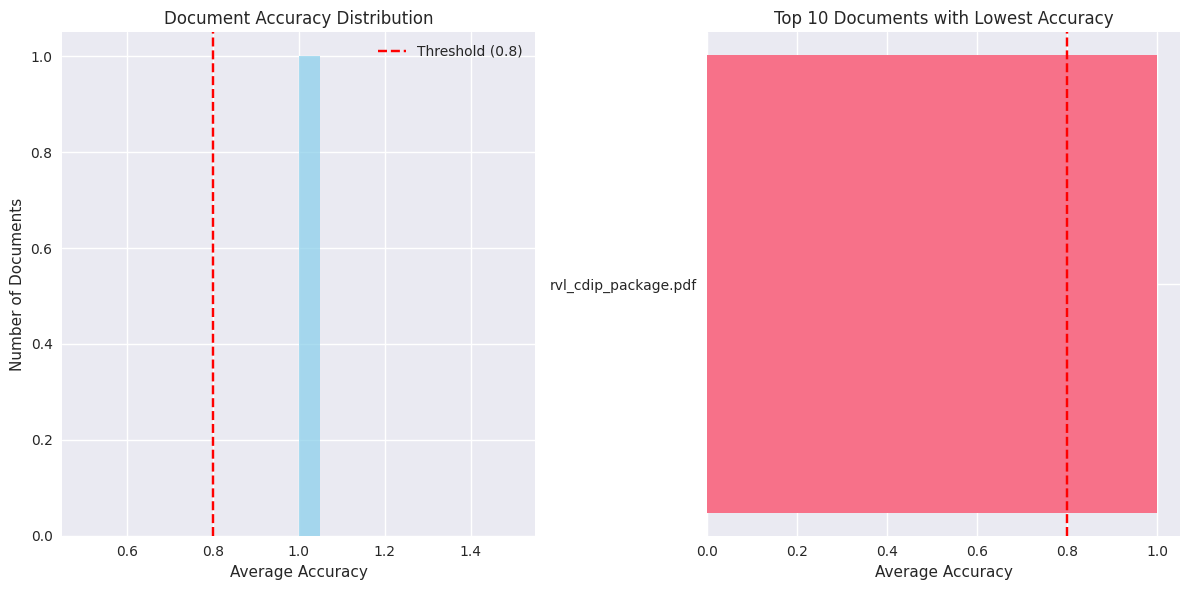

In [8]:
def analyze_document_accuracy_problems():
    """
    Find documents with the most accuracy problems
    """
    print("\n" + "="*60)
    print("DOCUMENTS WITH ACCURACY PROBLEMS")
    print("="*60)
    
    where_clause = build_where_clause()
    
    query = f"""
    SELECT 
        document_id,
        COUNT(*) as total_evaluations,
        ROUND(AVG(accuracy), 4) as avg_accuracy,
        ROUND(AVG(precision), 4) as avg_precision,
        ROUND(AVG(recall), 4) as avg_recall,
        ROUND(AVG(f1_score), 4) as avg_f1_score,
        MAX(evaluation_date) as latest_evaluation
    FROM document_evaluations 
    {where_clause}
    GROUP BY document_id
    ORDER BY avg_accuracy ASC
    LIMIT 20
    """
    
    result = execute_athena_query(query)
    
    if result is not None and not result.empty:
        # Convert numeric columns
        numeric_cols = ['total_evaluations', 'avg_accuracy', 'avg_precision', 'avg_recall', 'avg_f1_score']
        for col in numeric_cols:
            if col in result.columns:
                result[col] = pd.to_numeric(result[col], errors='coerce')
        
        # Highlight problematic documents
        problematic = result[result['avg_accuracy'] < MIN_ACCURACY_THRESHOLD]
        
        print(f"Found {len(result)} documents with evaluation data")
        print(f"Documents with accuracy below {MIN_ACCURACY_THRESHOLD}: {len(problematic)}")
        
        if not problematic.empty:
            print("\n🔴 DOCUMENTS REQUIRING ATTENTION (Low Accuracy):")
            print(problematic.to_string(index=False))
        
        print("\n📊 All Documents (Top 20 by lowest accuracy):")
        print(result.to_string(index=False))
        
        # Create visualization
        if len(result) > 0:
            plt.figure(figsize=(12, 6))
            
            # Plot accuracy distribution
            plt.subplot(1, 2, 1)
            plt.hist(result['avg_accuracy'], bins=20, alpha=0.7, color='skyblue')
            plt.axvline(MIN_ACCURACY_THRESHOLD, color='red', linestyle='--', label=f'Threshold ({MIN_ACCURACY_THRESHOLD})')
            plt.xlabel('Average Accuracy')
            plt.ylabel('Number of Documents')
            plt.title('Document Accuracy Distribution')
            plt.legend()
            
            # Plot top 10 worst performing documents
            plt.subplot(1, 2, 2)
            top_10 = result.head(10)
            plt.barh(range(len(top_10)), top_10['avg_accuracy'])
            plt.yticks(range(len(top_10)), [doc[:20] + '...' if len(doc) > 20 else doc for doc in top_10['document_id']])
            plt.xlabel('Average Accuracy')
            plt.title('Top 10 Documents with Lowest Accuracy')
            plt.axvline(MIN_ACCURACY_THRESHOLD, color='red', linestyle='--')
            
            plt.tight_layout()
            plt.show()
        
        return result
    else:
        print("No document evaluation data found")
        return None

doc_accuracy_df = analyze_document_accuracy_problems()

### 5.2 Sections with Most Accuracy Problems


SECTIONS WITH ACCURACY PROBLEMS
Found 8 different section types
Section types with accuracy below 0.8: 0

📊 All Section Types (by accuracy):
          section_type  total_sections  unique_documents  avg_accuracy  avg_precision  avg_recall  avg_f1_score
               invoice               1                 1           1.0            0.0         0.0           0.0
                letter               1                 1           1.0            1.0         1.0           1.0
scientific_publication               1                 1           1.0            1.0         1.0           1.0
                  form               1                 1           1.0            1.0         1.0           1.0
                resume               1                 1           1.0            1.0         1.0           1.0
         questionnaire               1                 1           1.0            1.0         1.0           1.0
                  memo               1                 1           1.0    

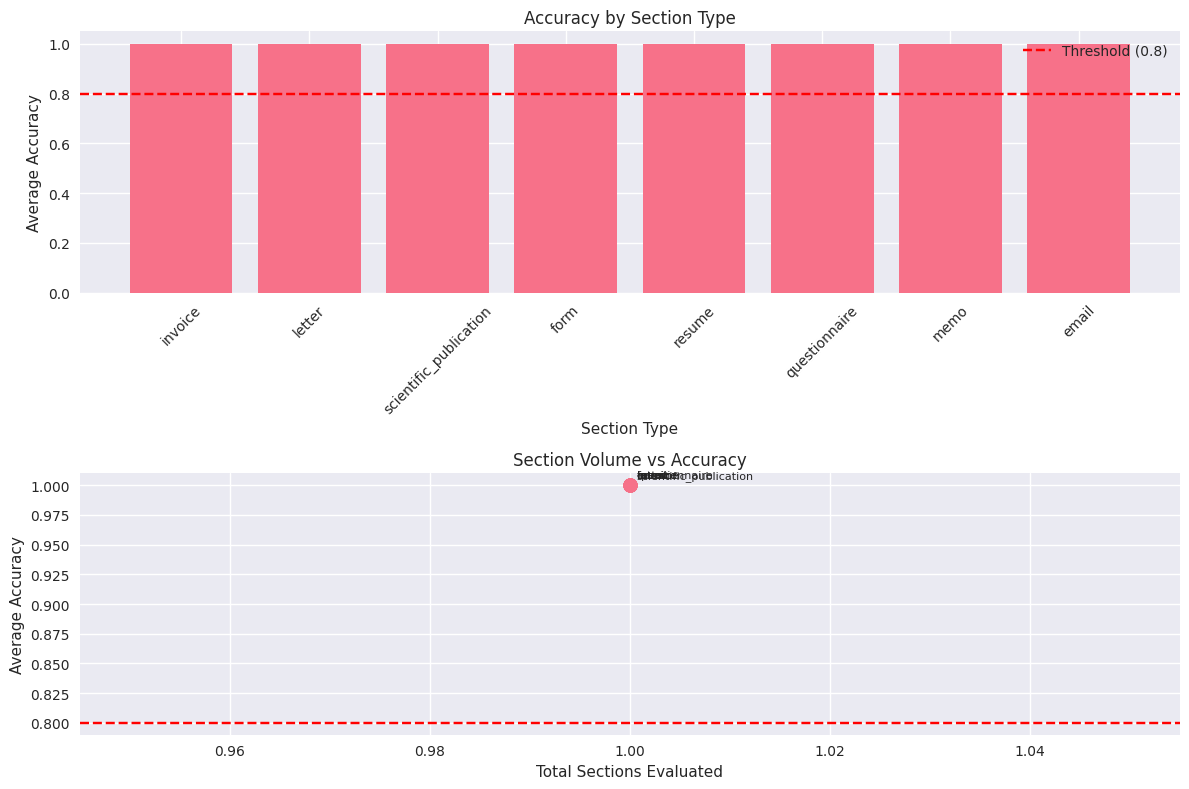

In [9]:
def analyze_section_accuracy_problems():
    """
    Find sections with the most accuracy problems
    """
    print("\n" + "="*60)
    print("SECTIONS WITH ACCURACY PROBLEMS")
    print("="*60)
    
    where_clause = build_where_clause()
    
    query = f"""
    SELECT 
        section_type,
        COUNT(*) as total_sections,
        COUNT(DISTINCT document_id) as unique_documents,
        ROUND(AVG(accuracy), 4) as avg_accuracy,
        ROUND(AVG(precision), 4) as avg_precision,
        ROUND(AVG(recall), 4) as avg_recall,
        ROUND(AVG(f1_score), 4) as avg_f1_score
    FROM section_evaluations 
    {where_clause}
    GROUP BY section_type
    ORDER BY avg_accuracy ASC
    """
    
    result = execute_athena_query(query)
    
    if result is not None and not result.empty:
        # Convert numeric columns
        numeric_cols = ['total_sections', 'unique_documents', 'avg_accuracy', 'avg_precision', 'avg_recall', 'avg_f1_score']
        for col in numeric_cols:
            if col in result.columns:
                result[col] = pd.to_numeric(result[col], errors='coerce')
        
        # Highlight problematic sections
        problematic = result[result['avg_accuracy'] < MIN_ACCURACY_THRESHOLD]
        
        print(f"Found {len(result)} different section types")
        print(f"Section types with accuracy below {MIN_ACCURACY_THRESHOLD}: {len(problematic)}")
        
        if not problematic.empty:
            print("\n🔴 SECTION TYPES REQUIRING ATTENTION:")
            print(problematic.to_string(index=False))
        
        print("\n📊 All Section Types (by accuracy):")
        print(result.to_string(index=False))
        
        # Create visualization
        if len(result) > 0:
            plt.figure(figsize=(12, 8))
            
            # Plot section type accuracy
            plt.subplot(2, 1, 1)
            plt.bar(result['section_type'], result['avg_accuracy'])
            plt.axhline(MIN_ACCURACY_THRESHOLD, color='red', linestyle='--', label=f'Threshold ({MIN_ACCURACY_THRESHOLD})')
            plt.xlabel('Section Type')
            plt.ylabel('Average Accuracy')
            plt.title('Accuracy by Section Type')
            plt.xticks(rotation=45)
            plt.legend()
            
            # Plot section volume vs accuracy
            plt.subplot(2, 1, 2)
            plt.scatter(result['total_sections'], result['avg_accuracy'], s=100, alpha=0.7)
            for i, section_type in enumerate(result['section_type']):
                plt.annotate(section_type, (result['total_sections'].iloc[i], result['avg_accuracy'].iloc[i]), 
                           xytext=(5, 5), textcoords='offset points', fontsize=8)
            plt.axhline(MIN_ACCURACY_THRESHOLD, color='red', linestyle='--')
            plt.xlabel('Total Sections Evaluated')
            plt.ylabel('Average Accuracy')
            plt.title('Section Volume vs Accuracy')
            
            plt.tight_layout()
            plt.show()
        
        return result
    else:
        print("No section evaluation data found")
        return None

section_accuracy_df = analyze_section_accuracy_problems()

### 5.3 Attributes with Most Accuracy Problems


ATTRIBUTES WITH ACCURACY PROBLEMS
Found 30 attribute-method combinations
Attributes with match rate below 0.8: 0

📊 All Attributes (Top 30 by lowest performance):
                    attribute_name  total_extractions  unique_documents  match_rate  avg_score evaluation_method
                        experience                  1                 1         1.0       0.95               LLM
                             items                  1                 1         1.0       1.00               LLM
                      contact_info                  1                 1         1.0       1.00               LLM
                              line                  1                 1         1.0       1.00               LLM
                             shift                  1                 1         1.0       1.00               LLM
                          abstract                  1                 1         1.0       1.00               LLM
                       description           

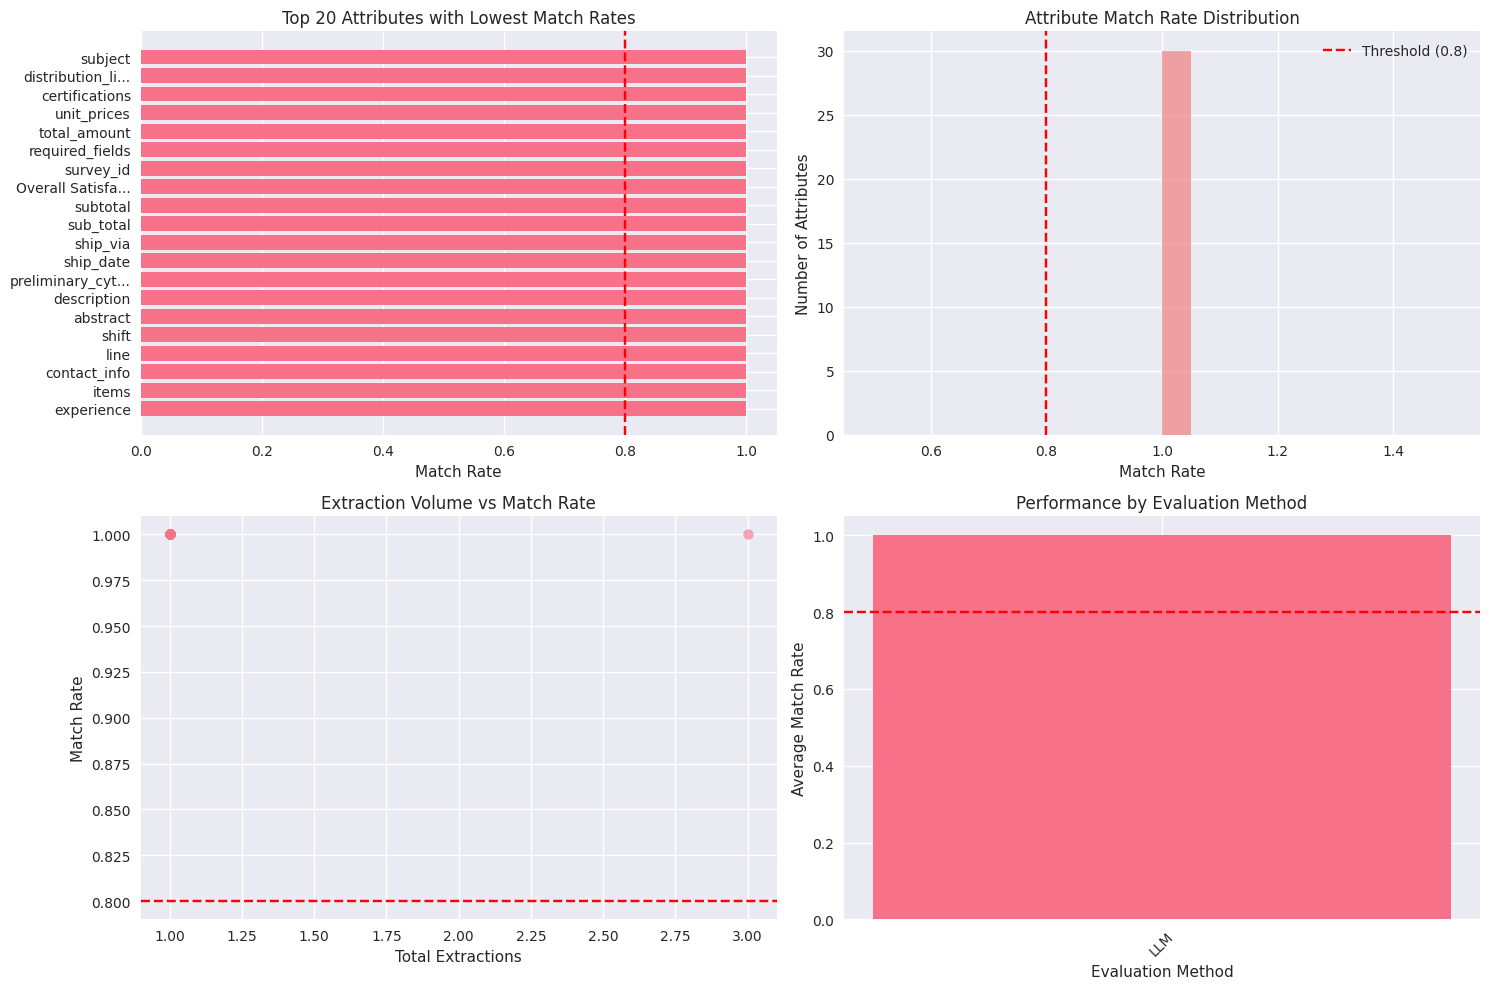

In [10]:
def analyze_attribute_accuracy_problems():
    """
    Find attributes with the most accuracy problems
    """
    print("\n" + "="*60)
    print("ATTRIBUTES WITH ACCURACY PROBLEMS")
    print("="*60)
    
    where_clause = build_where_clause()
    
    query = f"""
    SELECT 
        attribute_name,
        COUNT(*) as total_extractions,
        COUNT(DISTINCT document_id) as unique_documents,
        ROUND(AVG(CASE WHEN matched THEN 1.0 ELSE 0.0 END), 4) as match_rate,
        ROUND(AVG(score), 4) as avg_score,
        evaluation_method
    FROM attribute_evaluations 
    {where_clause}
    GROUP BY attribute_name, evaluation_method
    ORDER BY match_rate ASC, avg_score ASC
    LIMIT 30
    """
    
    result = execute_athena_query(query)
    
    if result is not None and not result.empty:
        # Convert numeric columns
        numeric_cols = ['total_extractions', 'unique_documents', 'match_rate', 'avg_score']
        for col in numeric_cols:
            if col in result.columns:
                result[col] = pd.to_numeric(result[col], errors='coerce')
        
        # Highlight problematic attributes (low match rate)
        problematic = result[result['match_rate'] < MIN_ACCURACY_THRESHOLD]
        
        print(f"Found {len(result)} attribute-method combinations")
        print(f"Attributes with match rate below {MIN_ACCURACY_THRESHOLD}: {len(problematic)}")
        
        if not problematic.empty:
            print("\n🔴 ATTRIBUTES REQUIRING ATTENTION (Low Match Rate):")
            print(problematic.to_string(index=False))
        
        print("\n📊 All Attributes (Top 30 by lowest performance):")
        print(result.to_string(index=False))
        
        # Get failure reasons for problematic attributes
        if not problematic.empty:
            print("\n🔍 COMMON FAILURE REASONS:")
            failure_query = f"""
            SELECT 
                attribute_name,
                reason,
                COUNT(*) as failure_count
            FROM attribute_evaluations 
            {where_clause}
            AND matched = false
            AND attribute_name IN ({','.join(["'" + attr + "'" for attr in problematic['attribute_name'].head(10)])})
            GROUP BY attribute_name, reason
            ORDER BY failure_count DESC
            LIMIT 20
            """
            
            failure_result = execute_athena_query(failure_query)
            if failure_result is not None and not failure_result.empty:
                print(failure_result.to_string(index=False))
        
        # Create visualization
        if len(result) > 0:
            plt.figure(figsize=(15, 10))
            
            # Plot attribute match rates
            plt.subplot(2, 2, 1)
            top_20 = result.head(20)
            plt.barh(range(len(top_20)), top_20['match_rate'])
            plt.yticks(range(len(top_20)), [attr[:15] + '...' if len(attr) > 15 else attr for attr in top_20['attribute_name']])
            plt.axvline(MIN_ACCURACY_THRESHOLD, color='red', linestyle='--')
            plt.xlabel('Match Rate')
            plt.title('Top 20 Attributes with Lowest Match Rates')
            
            # Plot match rate distribution
            plt.subplot(2, 2, 2)
            plt.hist(result['match_rate'], bins=20, alpha=0.7, color='lightcoral')
            plt.axvline(MIN_ACCURACY_THRESHOLD, color='red', linestyle='--', label=f'Threshold ({MIN_ACCURACY_THRESHOLD})')
            plt.xlabel('Match Rate')
            plt.ylabel('Number of Attributes')
            plt.title('Attribute Match Rate Distribution')
            plt.legend()
            
            # Plot volume vs performance
            plt.subplot(2, 2, 3)
            plt.scatter(result['total_extractions'], result['match_rate'], alpha=0.6)
            plt.axhline(MIN_ACCURACY_THRESHOLD, color='red', linestyle='--')
            plt.xlabel('Total Extractions')
            plt.ylabel('Match Rate')
            plt.title('Extraction Volume vs Match Rate')
            
            # Plot by evaluation method
            plt.subplot(2, 2, 4)
            if 'evaluation_method' in result.columns:
                method_stats = result.groupby('evaluation_method')['match_rate'].mean().sort_values()
                plt.bar(method_stats.index, method_stats.values)
                plt.axhline(MIN_ACCURACY_THRESHOLD, color='red', linestyle='--')
                plt.xlabel('Evaluation Method')
                plt.ylabel('Average Match Rate')
                plt.title('Performance by Evaluation Method')
                plt.xticks(rotation=45)
            
            plt.tight_layout()
            plt.show()
        
        return result
    else:
        print("No attribute evaluation data found")
        return None

attribute_accuracy_df = analyze_attribute_accuracy_problems()

## 6. Accuracy Trends Over Time

In [11]:
def analyze_accuracy_trends():
    """
    Analyze accuracy trends over time for documents
    """
    print("\n" + "="*60)
    print("ACCURACY TRENDS OVER TIME")
    print("="*60)
    
    where_clause = build_where_clause()
    
    # Get documents that have been evaluated multiple times
    multi_eval_query = f"""
    SELECT 
        document_id,
        COUNT(*) as evaluation_count,
        MIN(evaluation_date) as first_evaluation,
        MAX(evaluation_date) as latest_evaluation
    FROM document_evaluations 
    {where_clause}
    GROUP BY document_id
    HAVING COUNT(*) > 1
    ORDER BY evaluation_count DESC
    LIMIT 10
    """
    
    multi_eval_docs = execute_athena_query(multi_eval_query)
    
    if multi_eval_docs is not None and not multi_eval_docs.empty:
        print(f"Found {len(multi_eval_docs)} documents with multiple evaluations")
        print("\n📈 Documents with Multiple Evaluations:")
        print(multi_eval_docs.to_string(index=False))
        
        # Get detailed trend data for top documents
        top_docs = multi_eval_docs.head(5)['document_id'].tolist()
        doc_list = "','" .join(top_docs)
        
        trend_query = f"""
        SELECT 
            document_id,
            evaluation_date,
            accuracy,
            precision,
            recall,
            f1_score
        FROM document_evaluations 
        WHERE document_id IN ('{doc_list}')
        ORDER BY document_id, evaluation_date
        """
        
        trend_data = execute_athena_query(trend_query)
        
        if trend_data is not None and not trend_data.empty:
            # Convert data types
            trend_data['evaluation_date'] = pd.to_datetime(trend_data['evaluation_date'])
            numeric_cols = ['accuracy', 'precision', 'recall', 'f1_score']
            for col in numeric_cols:
                trend_data[col] = pd.to_numeric(trend_data[col], errors='coerce')
            
            # Analyze trends
            print("\n📊 TREND ANALYSIS:")
            for doc_id in top_docs:
                doc_data = trend_data[trend_data['document_id'] == doc_id].sort_values('evaluation_date')
                if len(doc_data) >= 2:
                    first_accuracy = doc_data.iloc[0]['accuracy']
                    latest_accuracy = doc_data.iloc[-1]['accuracy']
                    change = latest_accuracy - first_accuracy
                    trend = "📈 IMPROVING" if change > 0.01 else "📉 DECLINING" if change < -0.01 else "➡️ STABLE"
                    print(f"{doc_id[:30]}: {first_accuracy:.3f} → {latest_accuracy:.3f} ({change:+.3f}) {trend}")
            
            # Create trend visualization
            plt.figure(figsize=(15, 10))
            
            # Individual document trends
            plt.subplot(2, 2, 1)
            for doc_id in top_docs:
                doc_data = trend_data[trend_data['document_id'] == doc_id].sort_values('evaluation_date')
                plt.plot(doc_data['evaluation_date'], doc_data['accuracy'], marker='o', label=doc_id[:20] + '...')
            plt.axhline(MIN_ACCURACY_THRESHOLD, color='red', linestyle='--', alpha=0.7)
            plt.xlabel('Evaluation Date')
            plt.ylabel('Accuracy')
            plt.title('Accuracy Trends by Document')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.xticks(rotation=45)
            
            # Overall trend (daily averages)
            plt.subplot(2, 2, 2)
            daily_trends = trend_data.groupby(trend_data['evaluation_date'].dt.date)['accuracy'].mean().reset_index()
            daily_trends.columns = ['date', 'avg_accuracy']
            plt.plot(pd.to_datetime(daily_trends['date']), daily_trends['avg_accuracy'], marker='o', linewidth=2)
            plt.axhline(MIN_ACCURACY_THRESHOLD, color='red', linestyle='--', alpha=0.7)
            plt.xlabel('Date')
            plt.ylabel('Average Accuracy')
            plt.title('Overall Daily Accuracy Trend')
            plt.xticks(rotation=45)
            
            # Metric comparison over time
            plt.subplot(2, 2, 3)
            overall_trends = trend_data.groupby(trend_data['evaluation_date'].dt.date)[['accuracy', 'precision', 'recall', 'f1_score']].mean()
            for metric in ['accuracy', 'precision', 'recall', 'f1_score']:
                plt.plot(overall_trends.index, overall_trends[metric], marker='o', label=metric.title())
            plt.axhline(MIN_ACCURACY_THRESHOLD, color='red', linestyle='--', alpha=0.7)
            plt.xlabel('Date')
            plt.ylabel('Score')
            plt.title('All Metrics Trend Comparison')
            plt.legend()
            plt.xticks(rotation=45)
            
            # Distribution of accuracy changes
            plt.subplot(2, 2, 4)
            accuracy_changes = []
            for doc_id in trend_data['document_id'].unique():
                doc_data = trend_data[trend_data['document_id'] == doc_id].sort_values('evaluation_date')
                if len(doc_data) >= 2:
                    change = doc_data.iloc[-1]['accuracy'] - doc_data.iloc[0]['accuracy']
                    accuracy_changes.append(change)
            
            if accuracy_changes:
                plt.hist(accuracy_changes, bins=15, alpha=0.7, color='lightgreen')
                plt.axvline(0, color='black', linestyle='-', alpha=0.7, label='No Change')
                plt.xlabel('Accuracy Change (Latest - First)')
                plt.ylabel('Number of Documents')
                plt.title('Distribution of Accuracy Changes')
                plt.legend()
                
                improving = sum(1 for change in accuracy_changes if change > 0.01)
                declining = sum(1 for change in accuracy_changes if change < -0.01)
                stable = len(accuracy_changes) - improving - declining
                
                plt.text(0.02, 0.98, f'Improving: {improving}\nDeclining: {declining}\nStable: {stable}', 
                        transform=plt.gca().transAxes, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
            
            plt.tight_layout()
            plt.show()
            
            return trend_data
        
    else:
        print("No documents found with multiple evaluations")
        
        # Show overall trend if available
        overall_query = f"""
        SELECT 
            DATE(evaluation_date) as eval_date,
            COUNT(*) as evaluations_count,
            ROUND(AVG(accuracy), 4) as avg_accuracy,
            ROUND(AVG(precision), 4) as avg_precision,
            ROUND(AVG(recall), 4) as avg_recall
        FROM document_evaluations 
        {where_clause}
        GROUP BY DATE(evaluation_date)
        ORDER BY eval_date
        """
        
        overall_trend = execute_athena_query(overall_query)
        if overall_trend is not None and not overall_trend.empty:
            print("\n📊 Overall Daily Evaluation Trends:")
            print(overall_trend.to_string(index=False))
        
        return None

trend_data = analyze_accuracy_trends()


ACCURACY TRENDS OVER TIME
No documents found with multiple evaluations

📊 Overall Daily Evaluation Trends:
 eval_date evaluations_count avg_accuracy avg_precision avg_recall
2025-06-10                 1          1.0           1.0        1.0


## 7. Additional Useful Reports

### 7.1 Processing Time Analysis


PROCESSING TIME ANALYSIS
Analyzed 1 documents with processing time data
Average processing time: 56.68 seconds
Median processing time: 56.68 seconds
Max processing time: 56.68 seconds
Correlation between processing time and accuracy: nan


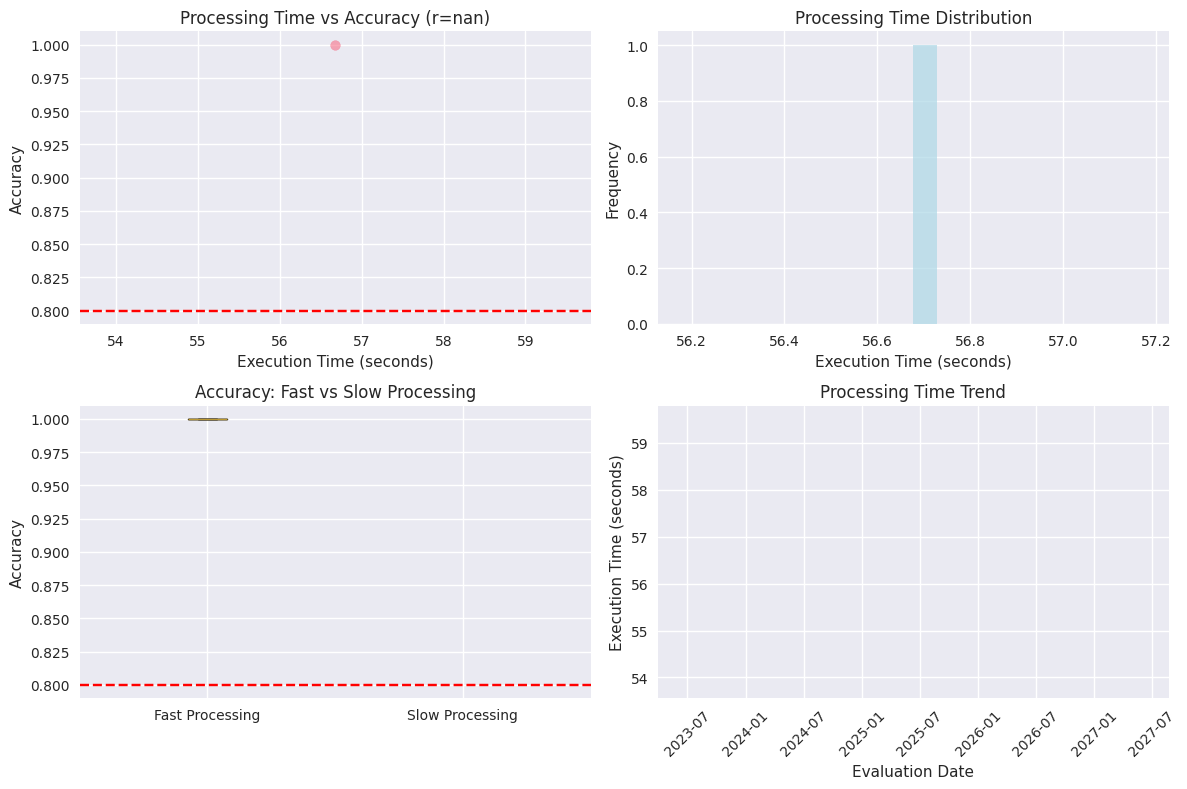

In [12]:
def analyze_processing_times():
    """
    Analyze processing times and their correlation with accuracy
    """
    print("\n" + "="*60)
    print("PROCESSING TIME ANALYSIS")
    print("="*60)
    
    where_clause = build_where_clause()
    
    query = f"""
    SELECT 
        document_id,
        execution_time,
        accuracy,
        evaluation_date
    FROM document_evaluations 
    {where_clause}
    AND execution_time IS NOT NULL
    ORDER BY execution_time DESC
    LIMIT 100
    """
    
    result = execute_athena_query(query)
    
    if result is not None and not result.empty:
        # Convert data types
        result['execution_time'] = pd.to_numeric(result['execution_time'], errors='coerce')
        result['accuracy'] = pd.to_numeric(result['accuracy'], errors='coerce')
        
        # Remove null values
        result = result.dropna(subset=['execution_time', 'accuracy'])
        
        if not result.empty:
            print(f"Analyzed {len(result)} documents with processing time data")
            print(f"Average processing time: {result['execution_time'].mean():.2f} seconds")
            print(f"Median processing time: {result['execution_time'].median():.2f} seconds")
            print(f"Max processing time: {result['execution_time'].max():.2f} seconds")
            
            # Find correlation
            correlation = result['execution_time'].corr(result['accuracy'])
            print(f"Correlation between processing time and accuracy: {correlation:.3f}")
            
            # Create visualization
            plt.figure(figsize=(12, 8))
            
            plt.subplot(2, 2, 1)
            plt.scatter(result['execution_time'], result['accuracy'], alpha=0.6)
            plt.xlabel('Execution Time (seconds)')
            plt.ylabel('Accuracy')
            plt.title(f'Processing Time vs Accuracy (r={correlation:.3f})')
            plt.axhline(MIN_ACCURACY_THRESHOLD, color='red', linestyle='--')
            
            plt.subplot(2, 2, 2)
            plt.hist(result['execution_time'], bins=20, alpha=0.7, color='lightblue')
            plt.xlabel('Execution Time (seconds)')
            plt.ylabel('Frequency')
            plt.title('Processing Time Distribution')
            
            # Slow vs fast processing accuracy comparison
            plt.subplot(2, 2, 3)
            median_time = result['execution_time'].median()
            fast_docs = result[result['execution_time'] <= median_time]
            slow_docs = result[result['execution_time'] > median_time]
            
            plt.boxplot([fast_docs['accuracy'].dropna(), slow_docs['accuracy'].dropna()], 
                       labels=['Fast Processing', 'Slow Processing'])
            plt.ylabel('Accuracy')
            plt.title('Accuracy: Fast vs Slow Processing')
            plt.axhline(MIN_ACCURACY_THRESHOLD, color='red', linestyle='--')
            
            # Processing time over time
            plt.subplot(2, 2, 4)
            result['evaluation_date'] = pd.to_datetime(result['evaluation_date'])
            result_sorted = result.sort_values('evaluation_date')
            plt.plot(result_sorted['evaluation_date'], result_sorted['execution_time'], alpha=0.7)
            plt.xlabel('Evaluation Date')
            plt.ylabel('Execution Time (seconds)')
            plt.title('Processing Time Trend')
            plt.xticks(rotation=45)
            
            plt.tight_layout()
            plt.show()
            
            return result
    else:
        print("No processing time data found")
        return None

processing_times_df = analyze_processing_times()

### 7.2 Evaluation Method Comparison

In [13]:
def compare_evaluation_methods():
    """
    Compare different evaluation methods
    """
    print("\n" + "="*60)
    print("EVALUATION METHOD COMPARISON")
    print("="*60)
    
    where_clause = build_where_clause()
    
    query = f"""
    SELECT 
        evaluation_method,
        COUNT(*) as total_evaluations,
        COUNT(DISTINCT document_id) as unique_documents,
        COUNT(DISTINCT attribute_name) as unique_attributes,
        ROUND(AVG(CASE WHEN matched THEN 1.0 ELSE 0.0 END), 4) as match_rate,
        ROUND(AVG(score), 4) as avg_score,
        ROUND(STDDEV(score), 4) as score_stddev
    FROM attribute_evaluations 
    {where_clause}
    GROUP BY evaluation_method
    ORDER BY match_rate DESC
    """
    
    result = execute_athena_query(query)
    
    if result is not None and not result.empty:
        # Convert numeric columns
        numeric_cols = ['total_evaluations', 'unique_documents', 'unique_attributes', 'match_rate', 'avg_score', 'score_stddev']
        for col in numeric_cols:
            if col in result.columns:
                result[col] = pd.to_numeric(result[col], errors='coerce')
        
        print(f"Found {len(result)} different evaluation methods")
        print("\n📊 Evaluation Method Performance:")
        print(result.to_string(index=False))
        
        # Find best and worst methods
        best_method = result.loc[result['match_rate'].idxmax()]['evaluation_method']
        worst_method = result.loc[result['match_rate'].idxmin()]['evaluation_method']
        
        print(f"\n🏆 Best performing method: {best_method} ({result['match_rate'].max():.3f} match rate)")
        print(f"⚠️ Worst performing method: {worst_method} ({result['match_rate'].min():.3f} match rate)")
        
        # Create visualization
        if len(result) > 1:
            plt.figure(figsize=(15, 10))
            
            # Match rate comparison
            plt.subplot(2, 2, 1)
            plt.bar(result['evaluation_method'], result['match_rate'])
            plt.axhline(MIN_ACCURACY_THRESHOLD, color='red', linestyle='--')
            plt.xlabel('Evaluation Method')
            plt.ylabel('Match Rate')
            plt.title('Match Rate by Evaluation Method')
            plt.xticks(rotation=45)
            
            # Volume comparison
            plt.subplot(2, 2, 2)
            plt.bar(result['evaluation_method'], result['total_evaluations'])
            plt.xlabel('Evaluation Method')
            plt.ylabel('Total Evaluations')
            plt.title('Evaluation Volume by Method')
            plt.xticks(rotation=45)
            
            # Score distribution
            plt.subplot(2, 2, 3)
            plt.scatter(result['avg_score'], result['match_rate'], s=result['total_evaluations']/10, alpha=0.7)
            for i, method in enumerate(result['evaluation_method']):
                plt.annotate(method, (result['avg_score'].iloc[i], result['match_rate'].iloc[i]), 
                           xytext=(5, 5), textcoords='offset points', fontsize=8)
            plt.xlabel('Average Score')
            plt.ylabel('Match Rate')
            plt.title('Score vs Match Rate (bubble size = volume)')
            
            # Coverage comparison
            plt.subplot(2, 2, 4)
            plt.scatter(result['unique_documents'], result['unique_attributes'], 
                       c=result['match_rate'], s=100, alpha=0.7, cmap='RdYlGn')
            plt.colorbar(label='Match Rate')
            for i, method in enumerate(result['evaluation_method']):
                plt.annotate(method, (result['unique_documents'].iloc[i], result['unique_attributes'].iloc[i]), 
                           xytext=(5, 5), textcoords='offset points', fontsize=8)
            plt.xlabel('Unique Documents')
            plt.ylabel('Unique Attributes')
            plt.title('Method Coverage (color = match rate)')
            
            plt.tight_layout()
            plt.show()
        
        return result
    else:
        print("No evaluation method data found")
        return None

method_comparison_df = compare_evaluation_methods()


EVALUATION METHOD COMPARISON
Found 1 different evaluation methods

📊 Evaluation Method Performance:
evaluation_method  total_evaluations  unique_documents  unique_attributes  match_rate  avg_score  score_stddev
              LLM                131                 1                121         1.0     0.9996        0.0044

🏆 Best performing method: LLM (1.000 match rate)
⚠️ Worst performing method: LLM (1.000 match rate)


## 8. Summary Report Generation

In [14]:
def generate_summary_report():
    """
    Generate a comprehensive summary report
    """
    print("\n" + "="*80)
    print("🚀 EVALUATION SUMMARY REPORT")
    print("="*80)
    
    where_clause = build_where_clause()
    
    # Overall statistics
    stats_queries = {
        'total_documents': f"SELECT COUNT(DISTINCT document_id) as count FROM document_evaluations {where_clause}",
        'total_doc_evaluations': f"SELECT COUNT(*) as count FROM document_evaluations {where_clause}",
        'total_section_evaluations': f"SELECT COUNT(*) as count FROM section_evaluations {where_clause}",
        'total_attribute_evaluations': f"SELECT COUNT(*) as count FROM attribute_evaluations {where_clause}",
        'avg_doc_accuracy': f"SELECT ROUND(AVG(accuracy), 4) as avg FROM document_evaluations {where_clause}",
        'avg_attr_match_rate': f"SELECT ROUND(AVG(CASE WHEN matched THEN 1.0 ELSE 0.0 END), 4) as avg FROM attribute_evaluations {where_clause}"
    }
    
    stats = {}
    for key, query in stats_queries.items():
        result = execute_athena_query(query)
        if result is not None and not result.empty:
            value = result.iloc[0].iloc[0]
            stats[key] = float(value) if value and value != '' else 0
        else:
            stats[key] = 0
    
    print(f"📊 OVERALL STATISTICS (Last {DATE_RANGE_DAYS} days)")
    print(f"   Total Documents Evaluated: {int(stats.get('total_documents', 0))}")
    print(f"   Total Document Evaluations: {int(stats.get('total_doc_evaluations', 0))}")
    print(f"   Total Section Evaluations: {int(stats.get('total_section_evaluations', 0))}")
    print(f"   Total Attribute Evaluations: {int(stats.get('total_attribute_evaluations', 0))}")
    print(f"   Average Document Accuracy: {stats.get('avg_doc_accuracy', 0):.3f}")
    print(f"   Average Attribute Match Rate: {stats.get('avg_attr_match_rate', 0):.3f}")
    
    # Health indicators
    print(f"\n🎯 HEALTH INDICATORS")
    doc_health = "✅ HEALTHY" if stats.get('avg_doc_accuracy', 0) >= MIN_ACCURACY_THRESHOLD else "⚠️ NEEDS ATTENTION"
    attr_health = "✅ HEALTHY" if stats.get('avg_attr_match_rate', 0) >= MIN_ACCURACY_THRESHOLD else "⚠️ NEEDS ATTENTION"
    
    print(f"   Document Accuracy: {doc_health} (Threshold: {MIN_ACCURACY_THRESHOLD})")
    print(f"   Attribute Matching: {attr_health} (Threshold: {MIN_ACCURACY_THRESHOLD})")
    
    # Top issues summary
    print(f"\n🚨 TOP ISSUES TO ADDRESS")
    
    if doc_accuracy_df is not None and not doc_accuracy_df.empty:
        worst_docs = doc_accuracy_df.head(3)
        print(f"   📄 Documents with lowest accuracy:")
        for _, row in worst_docs.iterrows():
            print(f"      • {row['document_id'][:40]}... (Accuracy: {row['avg_accuracy']:.3f})")
    
    if section_accuracy_df is not None and not section_accuracy_df.empty:
        worst_sections = section_accuracy_df.head(3)
        print(f"   📑 Section types with lowest accuracy:")
        for _, row in worst_sections.iterrows():
            print(f"      • {row['section_type']} (Accuracy: {row['avg_accuracy']:.3f})")
    
    if attribute_accuracy_df is not None and not attribute_accuracy_df.empty:
        worst_attrs = attribute_accuracy_df.head(3)
        print(f"   🏷️ Attributes with lowest match rates:")
        for _, row in worst_attrs.iterrows():
            print(f"      • {row['attribute_name']} (Match Rate: {row['match_rate']:.3f})")
    
    # Recommendations
    print(f"\n💡 RECOMMENDATIONS")
    
    if stats.get('avg_doc_accuracy', 0) < MIN_ACCURACY_THRESHOLD:
        print(f"   1. Document accuracy is below threshold - review extraction models and prompts")
    
    if stats.get('avg_attr_match_rate', 0) < MIN_ACCURACY_THRESHOLD:
        print(f"   2. Attribute matching needs improvement - check evaluation criteria and baselines")
    
    if trend_data is not None:
        print(f"   3. Monitor trends for documents with multiple evaluations")
    
    if method_comparison_df is not None and len(method_comparison_df) > 1:
        best_method = method_comparison_df.loc[method_comparison_df['match_rate'].idxmax()]['evaluation_method']
        print(f"   4. Consider using '{best_method}' evaluation method for better results")
    
    print(f"\n📅 Report generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"🔗 Database: {REPORTING_DATABASE}")
    print(f"🎛️ Filters: {DATE_RANGE_DAYS} days, Document filter: '{DOCUMENT_NAME_FILTER}'")
    
    return stats

summary_stats = generate_summary_report()


🚀 EVALUATION SUMMARY REPORT
📊 OVERALL STATISTICS (Last 30 days)
   Total Documents Evaluated: 1
   Total Document Evaluations: 1
   Total Section Evaluations: 8
   Total Attribute Evaluations: 131
   Average Document Accuracy: 1.000
   Average Attribute Match Rate: 1.000

🎯 HEALTH INDICATORS
   Document Accuracy: ✅ HEALTHY (Threshold: 0.8)
   Attribute Matching: ✅ HEALTHY (Threshold: 0.8)

🚨 TOP ISSUES TO ADDRESS
   📄 Documents with lowest accuracy:
      • rvl_cdip_package.pdf... (Accuracy: 1.000)
   📑 Section types with lowest accuracy:
      • invoice (Accuracy: 1.000)
      • letter (Accuracy: 1.000)
      • scientific_publication (Accuracy: 1.000)
   🏷️ Attributes with lowest match rates:
      • experience (Match Rate: 1.000)
      • items (Match Rate: 1.000)
      • contact_info (Match Rate: 1.000)

💡 RECOMMENDATIONS

📅 Report generated on: 2025-06-10 22:12:30
🔗 Database: idp-reporting-5-reporting-db
🎛️ Filters: 30 days, Document filter: ''


## 9. Export Results (Optional)

In [15]:
def export_results_to_csv():
    """
    Export analysis results to CSV files
    """
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    exports = [
        (doc_accuracy_df, f'document_accuracy_analysis_{timestamp}.csv'),
        (section_accuracy_df, f'section_accuracy_analysis_{timestamp}.csv'),
        (attribute_accuracy_df, f'attribute_accuracy_analysis_{timestamp}.csv'),
        (trend_data, f'accuracy_trends_{timestamp}.csv'),
        (processing_times_df, f'processing_times_{timestamp}.csv'),
        (method_comparison_df, f'method_comparison_{timestamp}.csv')
    ]
    
    exported_files = []
    
    for df, filename in exports:
        if df is not None and not df.empty:
            try:
                df.to_csv(filename, index=False)
                exported_files.append(filename)
                print(f"✅ Exported: {filename}")
            except Exception as e:
                print(f"❌ Failed to export {filename}: {str(e)}")
    
    if exported_files:
        print(f"\n📁 {len(exported_files)} files exported successfully")
    else:
        print("\n⚠️ No files were exported (no data available)")
    
    return exported_files

# Uncomment to export results
# exported_files = export_results_to_csv()
print("To export results to CSV files, uncomment and run the cell above")

To export results to CSV files, uncomment and run the cell above


## Usage Instructions

1. **Update Configuration**: Set your `REPORTING_DATABASE`, `AWS_REGION`, and `S3_OUTPUT_LOCATION` in the configuration cell

2. **Adjust Filters**: Modify `DATE_RANGE_DAYS`, `DOCUMENT_NAME_FILTER`, and `MIN_ACCURACY_THRESHOLD` as needed

3. **Run Analysis**: Execute all cells to generate comprehensive evaluation reports

4. **Interpret Results**: Look for:
   - Documents/sections/attributes with accuracy below threshold
   - Trends showing improvement or regression over time
   - Processing time correlations with accuracy
   - Evaluation method performance differences

5. **Export Data**: Uncomment the export cell to save results as CSV files

6. **Update Filters Dynamically**: Use `update_filters()` function to change parameters and re-run specific analyses

This notebook provides a comprehensive view of your document processing evaluation metrics and helps identify areas for improvement in your IDP pipeline.